In [1]:
pip install numpy pandas tensorflow matplotlib opencv-python

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten, Embedding
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import load_model

from PIL import Image
import torch
from torchvision import models
from torchvision.transforms import functional as F




In [16]:
base_dir = 'C:/Users/ASUS/Desktop/dogs_project/segmented_results'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70

In [17]:

def load_images(base_dir):
    X = []
    y = []
    count = 0
    categories = os.listdir(base_dir)  # 10 пород собак
    label_map = {category: idx for idx, category in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(base_dir, category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            count += 1
            image = cv2.imread(img_path)  # считывает изображение
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X.append(image)
            y.append(label_map[category])
        print(count)
    return np.array(X), np.array(y)

In [18]:
# Загружаем изображения и метки
X, y = load_images(base_dir)

# Нормализуем данные
X = X.astype('float32') / 255.0
y = to_categorical(y, num_classes=len(os.listdir(base_dir)))

# Разделяем данные на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

176
371
575
789
955
1091
1255
1433


In [19]:
print(X_train.shape, X_val.shape, X_test.shape)

(1003, 224, 224, 3) (215, 224, 224, 3) (215, 224, 224, 3)


In [22]:

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest',
)

test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

test_generator = val_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)


In [23]:

model = models.Sequential()

# Первый сверточный блок
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Второй сверточный блок
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Третий сверточный блок
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Четвертый сверточный блок
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Пятый сверточный блок
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Полносвязные слои
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Компиляция модели
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  
    metrics=['accuracy']
)

In [24]:
# Настройка EarlyStopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,  # 
    #callbacks=[early_stopping]  # Включение EarlyStopping
)

Epoch 1/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1234 - loss: 2.0741 - val_accuracy: 0.1349 - val_loss: 2.0279
Epoch 2/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1612 - loss: 1.9929 - val_accuracy: 0.2930 - val_loss: 1.8266
Epoch 3/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2720 - loss: 1.8673 - val_accuracy: 0.3442 - val_loss: 1.7087
Epoch 4/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2717 - loss: 1.7524 - val_accuracy: 0.2605 - val_loss: 1.6052
Epoch 5/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3112 - loss: 1.6389 - val_accuracy: 0.3860 - val_loss: 1.4982
Epoch 6/70
 5/32 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3473 - loss: 1.7224

KeyboardInterrupt: 

In [10]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Тестовая потеря: {test_loss}, Тестовая точность: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.8353 - loss: 0.4968
Тестовая потеря: 0.6436991095542908, Тестовая точность: 0.7875458002090454


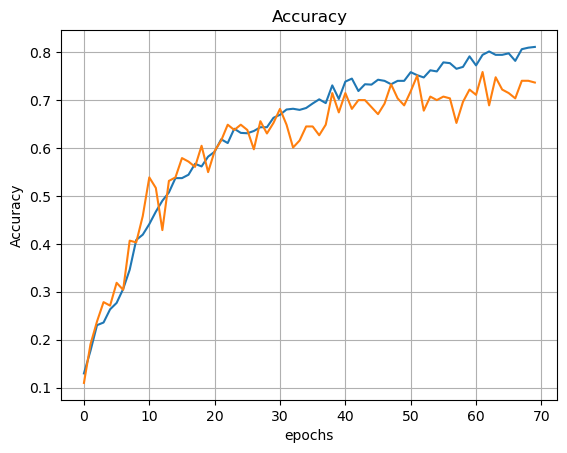

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.title("Accuracy")
plt.grid(True)
plt.show()

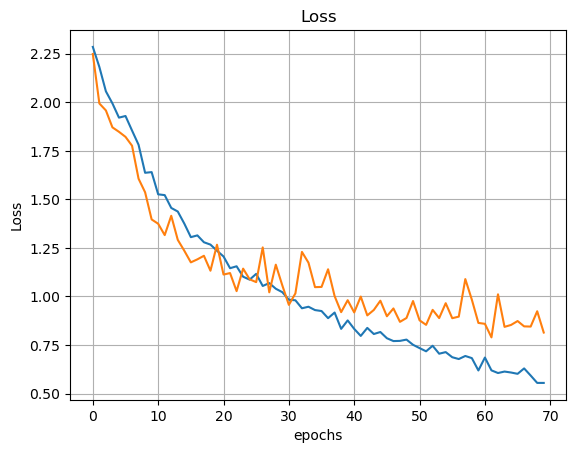

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.title("Loss")
plt.grid(True)
plt.show()

In [13]:
model.save('C:/Users/ASUS/Desktop/dogs_project/model78.h5')

In [2]:
model_saved = load_model('C:/Users/ASUS/Desktop/dogs_project/model75.h5')

In [3]:

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Предсказанный класс:  Rottweiler


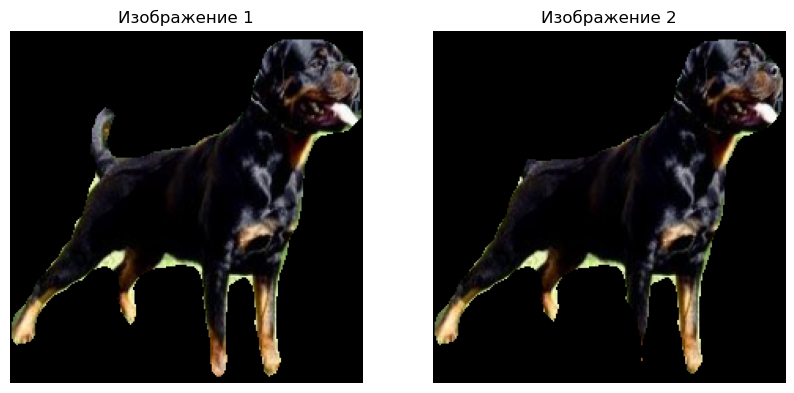

In [5]:
base_dir = 'C:/Users/ASUS/Desktop/dogs_project/segmented_results'
img_path = 'C:/Users/ASUS/Desktop/dogs_project/segmented_results/Rottweiler/n02106550_3931_14264_segmented_1.png'

def segment_dogs(image_path, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
       
    image_tensor = F.to_tensor(image).unsqueeze(0)

    # Get predictions
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Filter predictions for 'dog' class (COCO class id 18)
    dog_indices = [i for i, label in enumerate(predictions['labels']) if label == 18]

    if not dog_indices:
        print(f"No dogs detected in {image_path}")
        return None

    # Process each detected dog
    masks = predictions['masks'][dog_indices]
    scores = predictions['scores'][dog_indices]

    segmented_images = []

    for i, (mask, score) in enumerate(zip(masks, scores)):
        if score >= threshold:
            mask_np = mask.squeeze(0).mul(255).byte().cpu().numpy()

            # Create binary mask
            binary_mask = mask_np > 128

            # Extract the dog region
            image_np = np.array(image)
            segmented = image_np * binary_mask[:, :, None]
            segmented_images.append(segmented)
    #plt.imshow(segmented_images[0])
    return segmented_images[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
image = Image.open(img_path).convert("RGB")
    
axs[0].imshow(image)
axs[0].axis('off') 
axs[0].set_title('Изображение 1')
image = segment_dogs(img_path)
image = cv2.resize(image, (224,224))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_array = np.expand_dims(image, axis=0) / 255.0
prediction = model_saved.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)


categories = os.listdir(base_dir)  # Чтобы получить категории
predicted_label = categories[predicted_class[0]]

print("Предсказанный класс: ", predicted_label)   
axs[1].imshow(image)
axs[1].axis('off')  
axs[1].set_title('Изображение 2')  
plt.show()


